In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pip install pydicom numpy scikit-image scipy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 30.2 MB/s eta 0:00:00


In [11]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split

# Paths
raw_data_dir = "/content/drive/MyDrive/lung cancer"
preprocessed_data_dir = "/content/drive/MyDrive/lung cancer/preprocess_data"

# Parameters
img_size = (224, 224)   # match Inception input
channels = 3            # convert grayscale → RGB

# Remove old preprocess folder if exists
if os.path.exists(preprocessed_data_dir):
    shutil.rmtree(preprocessed_data_dir)
os.makedirs(preprocessed_data_dir, exist_ok=True)

# Data & Labels
data = []
labels = []
class_names = os.listdir(raw_data_dir)
class_names.sort()  # keep consistent class order

print("Classes:", class_names)

for label, class_name in enumerate(class_names):
    class_path = os.path.join(raw_data_dir, class_name)
    if os.path.isdir(class_path):
        print(f"Processing class: {class_name}")

        for img_name in tqdm(os.listdir(class_path)):
            img_path = os.path.join(class_path, img_name)

            # Read image (force grayscale)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            # Resize
            img = cv2.resize(img, img_size)

            # Normalize [0,1]
            img = img.astype(np.float32) / 255.0

            # Convert to 3 channels
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

            # Store
            data.append(img)
            labels.append(label)

# Convert to arrays
data = np.array(data, dtype=np.float32)
labels = np.array(labels)

print("✅ Total data shape:", data.shape)   # (N, 224, 224, 3)
print("✅ Labels shape:", labels.shape)

# --- Train / Val / Test Split ---
X_train, X_temp, y_train, y_temp = train_test_split(
    data, labels, test_size=0.3, stratify=labels, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("✅ Train:", X_train.shape, y_train.shape)
print("✅ Val:", X_val.shape, y_val.shape)
print("✅ Test:", X_test.shape, y_test.shape)

# Save splits
np.save(os.path.join(preprocessed_data_dir, "X_train.npy"), X_train)
np.save(os.path.join(preprocessed_data_dir, "y_train.npy"), y_train)
np.save(os.path.join(preprocessed_data_dir, "X_val.npy"), X_val)
np.save(os.path.join(preprocessed_data_dir, "y_val.npy"), y_val)
np.save(os.path.join(preprocessed_data_dir, "X_test.npy"), X_test)
np.save(os.path.join(preprocessed_data_dir, "y_test.npy"), y_test)

print("✅ Preprocessed train/val/test datasets saved in:", preprocessed_data_dir)


Classes: ['Bengin cases', 'Malignant cases', 'Normal cases', 'preprocess data', 'preprocess_data']
Processing class: Bengin cases


100%|██████████| 467/467 [00:11<00:00, 40.21it/s]


Processing class: Malignant cases


100%|██████████| 1050/1050 [00:45<00:00, 23.15it/s] 


Processing class: Normal cases


100%|██████████| 416/416 [00:12<00:00, 33.25it/s]


Processing class: preprocess data


0it [00:00, ?it/s]


Processing class: preprocess_data


0it [00:00, ?it/s]


✅ Total data shape: (1933, 224, 224, 3)
✅ Labels shape: (1933,)
✅ Train: (1353, 224, 224, 3) (1353,)
✅ Val: (290, 224, 224, 3) (290,)
✅ Test: (290, 224, 224, 3) (290,)
✅ Preprocessed train/val/test datasets saved in: /content/drive/MyDrive/lung cancer/preprocess_data


In [15]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ============================================================
# CONFIG
# ============================================================
raw_data_dir = "/content/drive/MyDrive/lung cancer"
preprocessed_data_dir = "/content/drive/MyDrive/lung cancer/preprocess_data_seq"

img_size = (224, 224)
channels = 3
sequence_length = 8   # number of slices per patient
seed = 42
batch_size = 8
epochs = 30

AUTOTUNE = tf.data.AUTOTUNE

# ============================================================
# STEP 1: PREPROCESS INTO SEQUENCES
# ============================================================
if os.path.exists(preprocessed_data_dir):
    shutil.rmtree(preprocessed_data_dir)
os.makedirs(preprocessed_data_dir, exist_ok=True)

data = []
labels = []
class_names = sorted(os.listdir(raw_data_dir))

print("Classes:", class_names)

for label, class_name in enumerate(class_names):
    class_path = os.path.join(raw_data_dir, class_name)
    if os.path.isdir(class_path):
        print(f"Processing class: {class_name}")

        patient_folders = [os.path.join(class_path, f) for f in os.listdir(class_path)]
        for patient in tqdm(patient_folders):
            if os.path.isdir(patient):
                slice_imgs = []
                for img_name in sorted(os.listdir(patient))[:sequence_length]:
                    img_path = os.path.join(patient, img_name)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is None: continue
                    img = cv2.resize(img, img_size)
                    img = img.astype(np.float32) / 255.0
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                    slice_imgs.append(img)

                # Pad if patient has < sequence_length slices
                while len(slice_imgs) < sequence_length:
                    slice_imgs.append(np.zeros((224,224,3), dtype=np.float32))

                data.append(np.array(slice_imgs))
                labels.append(label)

data = np.array(data, dtype=np.float32)
labels = np.array(labels)

print("✅ Data shape:", data.shape)   # (N, T, 224, 224, 3)
print("✅ Labels shape:", labels.shape)

# ============================================================
# STEP 2: TRAIN/VAL/TEST SPLIT
# ============================================================
X_train, X_temp, y_train, y_temp = train_test_split(
    data, labels, test_size=0.3, stratify=labels, random_state=seed
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=seed
)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

# ============================================================
# STEP 3: DATA PIPELINE
# ============================================================
def make_ds(X, y, training=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(512, seed=seed, reshuffle_each_iteration=True)

    def _prep(x, y):
        return x, tf.one_hot(y, depth=len(class_names))

    ds = ds.map(_prep, num_parallel_calls=AUTOTUNE, deterministic=not training)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(X_train, y_train, training=True)
val_ds   = make_ds(X_val, y_val, training=False)
test_ds  = make_ds(X_test, y_test, training=False)

# ============================================================
# STEP 4: MODEL - Inception CNN + LSTM
# ============================================================
base_cnn = keras.applications.InceptionV3(
    include_top=False, weights="imagenet", pooling="avg", input_shape=(224,224,3)
)

base_cnn.trainable = False  # fine-tune later if needed

def build_model(sequence_length=sequence_length, n_classes=len(class_names)):
    inputs = keras.Input((sequence_length, 224, 224, 3))

    # CNN encoder applied to each slice
    encoded = layers.TimeDistributed(base_cnn)(inputs)

    # LSTM over sequence of slice embeddings
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(encoded)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    return model

model = build_model()
model.summary()

# ============================================================
# STEP 5: TRAINING
# ============================================================
opt = keras.optimizers.Adam(1e-4)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.AUC(name="auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall")
    ]
)

cbs = [
    keras.callbacks.ModelCheckpoint(
        "/content/drive/MyDrive/lung cancer/best_cnn_inception_lstm_seq.keras",
        save_best_only=True,
        monitor="val_auc",
        mode="max"
    ),
    keras.callbacks.EarlyStopping(monitor="val_auc", patience=5, mode="max", restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=cbs,
    verbose=1
)

# ============================================================
# STEP 6: EVALUATION
# ============================================================
results = model.evaluate(test_ds)
print("✅ Test Results:", dict(zip(model.metrics_names, results)))


Classes: ['Bengin cases', 'Malignant cases', 'Normal cases', 'best_cnn_inception_lstm.keras', 'preprocess data', 'preprocess_data', 'preprocess_data_seq']
Processing class: Bengin cases


100%|██████████| 467/467 [00:00<00:00, 5985.27it/s]


Processing class: Malignant cases


100%|██████████| 1050/1050 [00:00<00:00, 5872.40it/s]


Processing class: Normal cases


100%|██████████| 416/416 [00:00<00:00, 6547.08it/s]


Processing class: preprocess data


0it [00:00, ?it/s]


Processing class: preprocess_data


100%|██████████| 6/6 [00:00<00:00, 3385.69it/s]


Processing class: preprocess_data_seq


0it [00:00, ?it/s]


✅ Data shape: (0,)
✅ Labels shape: (0,)


ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [16]:
# ============================================================
# STEP 1: PREPROCESS INTO SEQUENCES (FIXED)
# ============================================================
valid_classes = ["Bengin cases", "Malignant cases", "Normal cases"]  # only real classes

data = []
labels = []

for label, class_name in enumerate(valid_classes):
    class_path = os.path.join(raw_data_dir, class_name)
    print(f"Processing class: {class_name}")

    # Each patient is a folder inside the class
    patient_folders = [os.path.join(class_path, f) for f in os.listdir(class_path)]
    for patient in tqdm(patient_folders):
        if os.path.isdir(patient):
            slice_imgs = []
            for img_name in sorted(os.listdir(patient))[:sequence_length]:
                img_path = os.path.join(patient, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = cv2.resize(img, img_size)
                img = img.astype(np.float32) / 255.0
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                slice_imgs.append(img)

            # Pad if fewer slices than required
            while len(slice_imgs) < sequence_length:
                slice_imgs.append(np.zeros((224,224,3), dtype=np.float32))

            data.append(np.array(slice_imgs))
            labels.append(label)

data = np.array(data, dtype=np.float32)
labels = np.array(labels)

print("✅ Data shape:", data.shape)   # should be (N, T, 224, 224, 3)
print("✅ Labels shape:", labels.shape)


Processing class: Bengin cases


100%|██████████| 467/467 [00:00<00:00, 5784.48it/s]


Processing class: Malignant cases


100%|██████████| 1050/1050 [00:00<00:00, 6250.78it/s]


Processing class: Normal cases


100%|██████████| 416/416 [00:00<00:00, 9217.62it/s]

✅ Data shape: (0,)
✅ Labels shape: (0,)


In [17]:
valid_classes = ["Bengin cases", "Malignant cases", "Normal cases"]


In [18]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ============================================================
# CONFIG
# ============================================================
raw_data_dir = "/content/drive/MyDrive/lung cancer"
preprocessed_data_dir = "/content/drive/MyDrive/lung cancer/preprocess_data_seq"

img_size = (224, 224)
channels = 3
sequence_length = 8   # number of slices per patient
seed = 42
batch_size = 8
epochs = 30

AUTOTUNE = tf.data.AUTOTUNE

# ============================================================
# STEP 1: PREPROCESS INTO SEQUENCES
# ============================================================
valid_classes = ["Bengin cases", "Malignant cases", "Normal cases"]

if os.path.exists(preprocessed_data_dir):
    shutil.rmtree(preprocessed_data_dir)
os.makedirs(preprocessed_data_dir, exist_ok=True)

data = []
labels = []

for label, class_name in enumerate(valid_classes):
    class_path = os.path.join(raw_data_dir, class_name)
    print(f"Processing class: {class_name}")

    # each patient is a folder inside the class
    patient_folders = [os.path.join(class_path, f) for f in os.listdir(class_path)]
    for patient in tqdm(patient_folders):
        if os.path.isdir(patient):
            slice_imgs = []
            for img_name in sorted(os.listdir(patient))[:sequence_length]:
                img_path = os.path.join(patient, img_name)

                # skip non-image files
                if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue

                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = cv2.resize(img, img_size)
                img = img.astype(np.float32) / 255.0
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                slice_imgs.append(img)

            # Pad if patient has < sequence_length slices
            while len(slice_imgs) < sequence_length:
                slice_imgs.append(np.zeros((224,224,3), dtype=np.float32))

            if len(slice_imgs) == sequence_length:  # only add if sequence is complete
                data.append(np.array(slice_imgs))
                labels.append(label)

data = np.array(data, dtype=np.float32)
labels = np.array(labels)

print("✅ Data shape:", data.shape)   # (N, T, 224, 224, 3)
print("✅ Labels shape:", labels.shape)

# ============================================================
# STEP 2: TRAIN/VAL/TEST SPLIT
# ============================================================
X_train, X_temp, y_train, y_temp = train_test_split(
    data, labels, test_size=0.3, stratify=labels, random_state=seed
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=seed
)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

# ============================================================
# STEP 3: DATA PIPELINE
# ============================================================
def make_ds(X, y, training=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(512, seed=seed, reshuffle_each_iteration=True)

    def _prep(x, y):
        return x, tf.one_hot(y, depth=len(valid_classes))

    ds = ds.map(_prep, num_parallel_calls=AUTOTUNE, deterministic=not training)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(X_train, y_train, training=True)
val_ds   = make_ds(X_val, y_val, training=False)
test_ds  = make_ds(X_test, y_test, training=False)

# ============================================================
# STEP 4: MODEL - Inception CNN + LSTM
# ============================================================
base_cnn = keras.applications.InceptionV3(
    include_top=False, weights="imagenet", pooling="avg", input_shape=(224,224,3)
)
base_cnn.trainable = False  # fine-tune later if needed

def build_model(sequence_length=sequence_length, n_classes=len(valid_classes)):
    inputs = keras.Input((sequence_length, 224, 224, 3))

    # CNN encoder applied to each slice
    encoded = layers.TimeDistributed(base_cnn)(inputs)

    # LSTM over sequence of slice embeddings
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(encoded)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    return model

model = build_model()
model.summary()

# ============================================================
# STEP 5: TRAINING
# ============================================================
opt = keras.optimizers.Adam(1e-4)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.AUC(name="auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall")
    ]
)

cbs = [
    keras.callbacks.ModelCheckpoint(
        "/content/drive/MyDrive/lung cancer/best_cnn_inception_lstm_seq.keras",
        save_best_only=True,
        monitor="val_auc",
        mode="max"
    ),
    keras.callbacks.EarlyStopping(monitor="val_auc", patience=5, mode="max", restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=cbs,
    verbose=1
)

# ============================================================
# STEP 6: EVALUATION
# ============================================================
results = model.evaluate(test_ds)
print("✅ Test Results:", dict(zip(model.metrics_names, results)))


Processing class: Bengin cases


100%|██████████| 467/467 [00:00<00:00, 4837.57it/s]


Processing class: Malignant cases


100%|██████████| 1050/1050 [00:00<00:00, 7532.29it/s]


Processing class: Normal cases


100%|██████████| 416/416 [00:00<00:00, 8071.04it/s]

✅ Data shape: (0,)
✅ Labels shape: (0,)


ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [19]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ============================================================
# CONFIG
# ============================================================
raw_data_dir = "/content/drive/MyDrive/lung cancer"
preprocessed_data_dir = "/content/drive/MyDrive/lung cancer/preprocess_data"

img_size = (224, 224)
channels = 3
seed = 42
batch_size = 16
epochs = 30

AUTOTUNE = tf.data.AUTOTUNE
valid_classes = ["Bengin cases", "Malignant cases", "Normal cases"]

# ============================================================
# STEP 1: PREPROCESS (IMAGES ONLY)
# ============================================================
if os.path.exists(preprocessed_data_dir):
    shutil.rmtree(preprocessed_data_dir)
os.makedirs(preprocessed_data_dir, exist_ok=True)

data, labels = [], []

for label, class_name in enumerate(valid_classes):
    class_path = os.path.join(raw_data_dir, class_name)
    print(f"Processing class: {class_name}")

    for img_name in tqdm(os.listdir(class_path)):
        img_path = os.path.join(class_path, img_name)

        # skip non-image files
        if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, img_size)
        img = img.astype(np.float32) / 255.0
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # 3-channels
        data.append(img)
        labels.append(label)

data = np.array(data, dtype=np.float32)
labels = np.array(labels)

print("✅ Data shape:", data.shape)   # (N, 224, 224, 3)
print("✅ Labels shape:", labels.shape)

# ============================================================
# STEP 2: TRAIN/VAL/TEST SPLIT
# ============================================================
X_train, X_temp, y_train, y_temp = train_test_split(
    data, labels, test_size=0.3, stratify=labels, random_state=seed
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=seed
)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

# ============================================================
# STEP 3: DATA PIPELINE
# ============================================================
def make_ds(X, y, training=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(1024, seed=seed, reshuffle_each_iteration=True)

    def _prep(x, y):
        return x, tf.one_hot(y, depth=len(valid_classes))

    ds = ds.map(_prep, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(X_train, y_train, training=True)
val_ds   = make_ds(X_val, y_val, training=False)
test_ds  = make_ds(X_test, y_test, training=False)

# ============================================================
# STEP 4: MODEL - InceptionV3
# ============================================================
base_cnn = keras.applications.InceptionV3(
    include_top=False, weights="imagenet", pooling="avg", input_shape=(224,224,3)
)
base_cnn.trainable = False

inputs = keras.Input((224,224,3))
x = base_cnn(inputs, training=False)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(valid_classes), activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

# ============================================================
# STEP 5: TRAINING
# ============================================================
opt = keras.optimizers.Adam(1e-4)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.AUC(name="auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall")
    ]
)

cbs = [
    keras.callbacks.ModelCheckpoint(
        "/content/drive/MyDrive/lung cancer/best_cnn_inception.keras",
        save_best_only=True,
        monitor="val_auc",
        mode="max"
    ),
    keras.callbacks.EarlyStopping(monitor="val_auc", patience=5, mode="max", restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=cbs,
    verbose=1
)

# ============================================================
# STEP 6: EVALUATION
# ============================================================
results = model.evaluate(test_ds)
print("✅ Test Results:", dict(zip(model.metrics_names, results)))


Processing class: Bengin cases


100%|██████████| 467/467 [00:06<00:00, 66.76it/s] 


Processing class: Malignant cases


100%|██████████| 1050/1050 [00:19<00:00, 53.29it/s]


Processing class: Normal cases


100%|██████████| 416/416 [00:07<00:00, 52.99it/s]


✅ Data shape: (1933, 224, 224, 3)
✅ Labels shape: (1933,)
Train: (1353, 224, 224, 3) (1353,)
Val: (290, 224, 224, 3) (290,)
Test: (290, 224, 224, 3) (290,)
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 2048)           │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,328,099 (85.17 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 249s 3s/step - accuracy: 0.6084 - auc: 0.7881 - loss: 0.8873 - precision: 0.6263 - recall: 0.5498 - val_accuracy: 0.8000 - val_auc: 0.9555 - val_loss: 0.3927 - val_precision: 0.8156 - val_recall: 0.7931
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.7971 - auc: 0.9436 - loss: 0.4415 - precision: 0.8138 - recall: 0.7751 - val_accuracy: 0.8621 - val_auc: 0.9740 - val_loss: 0.3155 - val_precision: 0.8719 - val_recall: 0.8448
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 256s 3s/step - accuracy: 0.8431 - auc: 0.9655 - loss: 0.3481 - precision: 0.8482 - recall: 0.8357 - val_accuracy: 0.8586 - val_auc: 0.9711 - val_loss: 0.3175 - val_precision: 0.8581 - val_recall: 0.8552
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.8785 - auc: 0.9732 - loss: 0.3074 - precision: 0.8832 - recall: 0.8696 - val_accuracy: 0.8621 - val_auc: 0.9741 - val_loss: 0.2924 - val_precision: 0.8646 - val_recall: 0.8586
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━

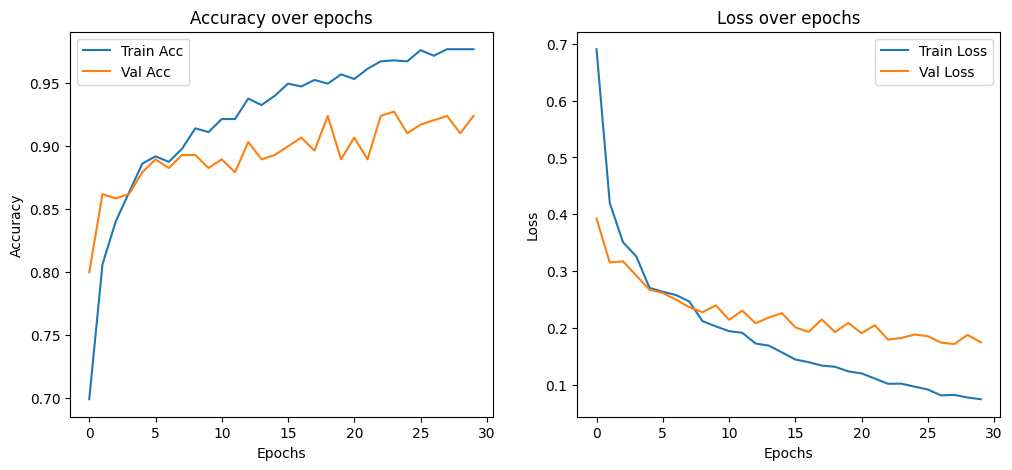

19/19 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step


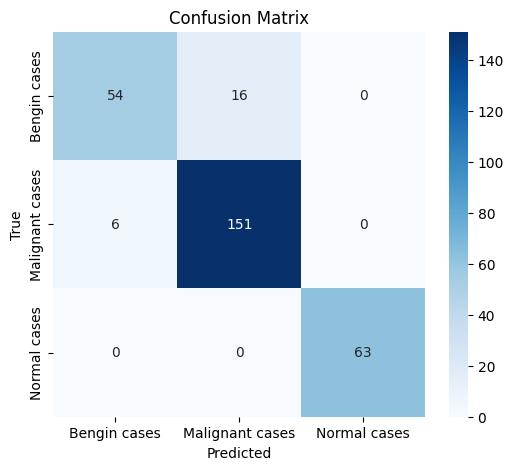

Classification Report:
                 precision    recall  f1-score   support

   Bengin cases       0.90      0.77      0.83        70
Malignant cases       0.90      0.96      0.93       157
   Normal cases       1.00      1.00      1.00        63

       accuracy                           0.92       290
      macro avg       0.93      0.91      0.92       290
   weighted avg       0.92      0.92      0.92       290



In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ============================================================
# PLOT TRAINING CURVES
# ============================================================
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training(history)

# ============================================================
# CONFUSION MATRIX & CLASSIFICATION REPORT
# ============================================================
# Get predictions
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=valid_classes,
            yticklabels=valid_classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=valid_classes))


In [23]:
import os

base_dir = "/content/drive/MyDrive/lung cancer"

for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if os.path.isdir(class_path):
        print(f"\nClass: {class_name}")
        items = os.listdir(class_path)
        print("  Sample files:", items[:5])   # show first 5 items
        print("  Total items:", len(items))



Class: Normal cases
  Sample files: ['Normal case (125).jpg', 'Normal case (136).jpg', 'Normal case (132).jpg', 'Normal case (121).jpg', 'Normal case (115).jpg']
  Total items: 416

Class: Malignant cases
  Sample files: ['Malignant (1024).JPG', 'Malignant (109).JPG', 'Malignant (1025).JPG', 'Malignant (1041).JPG', 'Malignant (102).JPG']
  Total items: 1050

Class: Bengin cases
  Sample files: ['Benign (100).JPG', 'Benign (101).JPG', 'Benign (102).JPG', 'Benign (10).JPG', 'Benign (1).JPG']
  Total items: 467

Class: preprocess data
  Sample files: []
  Total items: 0

Class: preprocess_data_seq
  Sample files: ['data.npy', 'labels.npy']
  Total items: 2

Class: preprocess_data
  Sample files: []
  Total items: 0
